In [3]:
import time
import sys
import pathlib
import os
import numpy as np
import cv2 as cv
from spatialmath import SE3
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from spatialmath.base import trotx, troty, trotz

# Fix for notebooks: add the parent directory to sys.path
notebook_path = os.getcwd()
sys.path.append(str(pathlib.Path(notebook_path).parent))

# Now import your custom robot class
from classrobot.UR5e_DH import UR5eDH
import roboticstoolbox as rtb


In [4]:
def cubic_trajectory_scalar(p0, p1, v0, v1, T, dt):
    """
    Compute a cubic polynomial trajectory for a single coordinate.
    
    The polynomial is:
        p(t) = a*t^3 + b*t^2 + v0*t + p0
    with coefficients:
        a = [2*(p0 - p1) + (v0 + v1)*T] / T^3
        b = [3*(p1 - p0) - (2*v0 + v1)*T] / T^2

    Returns the time vector, positions and velocities.
    """
    t = np.arange(0, T + dt, dt)
    a = (2 * (p0 - p1) + (v0 + v1) * T) / (T**3)
    b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T**2)
    pos = a * t**3 + b * t**2 + v0 * t + p0
    vel = 3 * a * t**2 + 2 * b * t + v0
    return t, pos, vel

In [6]:
robot = UR5eDH()
tool_offset = SE3(0, 0, 0.2)
robot.tool = tool_offset
print(robot)


DHRobot: UR5e (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ    │   ⍺ⱼ   │
├─────┼────────┼─────────┼────────┤
│  q1 │ 0.1625 │       0 │  90.0° │
│  q2 │      0 │  -0.425 │   0.0° │
│  q3 │      0 │ -0.3922 │   0.0° │
│  q4 │ 0.1333 │       0 │  90.0° │
│  q5 │ 0.0997 │       0 │ -90.0° │
│  q6 │ 0.0996 │       0 │   0.0° │
└─────┴────────┴─────────┴────────┘

┌──────┬─────────────────────────────────────┐
│ tool │ t = 0, 0, 0.2; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌────────┬────────┬───────┬───────┬───────┬────────┬───────┐
│   name │ q0     │ q1    │ q2    │ q3    │ q4     │ q5    │
├────────┼────────┼───────┼───────┼───────┼────────┼───────┤
│     qr │  180°  │  0°   │  0°   │  0°   │  90°   │  0°   │
│     qz │  0°    │  0°   │  0°   │  0°   │  0°    │  0°   │
│ q_HOME │  41.6° │ -111° │ -117° │ -130° │ -50.6° │  136° │
└────────┴────────┴───────┴───────┴─────

In [27]:
pos_home = [0.7011797304915488, 0.18427154391614353, 0.17217411213036665,
            -1.7318443587261685, 0.686842056802218, -1.7312759524010408]
pos_right_bottom = [0.6158402179629584, 0.18424774957164802, -0.43708867396716417,
                    -1.7320526609998639, 0.6867495616307455, -1.7312152841633146]

# --- 3. Build SE3 objects from the TCP pose vectors ---
# Here we assume the ordering: [x, y, z, roll, pitch, yaw]
T_start = SE3(pos_home[0], pos_home[1], pos_home[2]) @ SE3.RPY(pos_home[3], pos_home[4], pos_home[5], unit='rad')
T_end   = SE3(pos_right_bottom[0], pos_right_bottom[1], pos_right_bottom[2]) @ SE3.RPY(pos_right_bottom[3], pos_right_bottom[4], pos_right_bottom[5], unit='rad')

print("Start TCP Pose:\n", T_start)
print("Target TCP Pose:\n", T_end)


Start TCP Pose:
   -0.1236   -0.05828   0.9906    0.7012    
  -0.7633    0.6435   -0.05735   0.1843    
  -0.6341   -0.7632   -0.124     0.1722    
   0         0         0         1         

Target TCP Pose:
   -0.1235   -0.05854   0.9906    0.6158    
  -0.7634    0.6434   -0.05717   0.1842    
  -0.634    -0.7633   -0.1242   -0.4371    
   0         0         0         1         



In [34]:
# --- 4. Generate a Cartesian trajectory between the two TCP poses ---
T_total = 5.0   # Total trajectory duration (seconds)
dt = 0.01       # Control loop time step

# Time vector for the trajectory
t_vec = np.arange(0, T_total + dt, dt)

# Generate the translational (x, y, z) trajectory using cubic interpolation.
pos_traj = np.zeros((len(t_vec), 3))
# Zero initial and final Cartesian velocities (for a smooth start/stop)
v0_cart = 0.0
v1_cart = 0.0

# Extract the translation from T_start and T_end
pos_start = T_start.t  # This is a (3,) numpy array [x, y, z]
pos_end   = T_end.t

for i in range(3):
    _, pos_traj[:, i], _ = cubic_trajectory_scalar(pos_start[i], pos_end[i],
                                                    v0_cart, v1_cart,
                                                    T_total, dt)
    # print(f"pos_traj[:, {i}]: {pos_traj[:, i]}")

# how many points in the trajectory?
print("Number of points in the trajectory:", len(pos_traj))

# For the orientation, interpolate using the SE3.interp method.
traj_T = []
for j, t in enumerate(t_vec):
    s = t / T_total  # normalized time [0, 1]
    # Interpolate the full SE3 pose
    T_interp = T_start.interp(T_end, s)
    # Replace the translation with the cubic trajectory value for consistency
    T_interp = SE3.Rt(T_interp.R[:3, :3], pos_traj[j, :])  # Ensure R is a 3x3 rotation matrix
    traj_T.append(T_interp)

print("Interpolated TCP poses:")
for T in traj_T:
    print(T)

print(len(traj_T))

Number of points in the trajectory: 501
Interpolated TCP poses:
  -0.1236   -0.05828   0.9906    0.7012    
  -0.7633    0.6435   -0.05735   0.1843    
  -0.6341   -0.7632   -0.124     0.1722    
   0         0         0         1         

  -0.1236   -0.05828   0.9906    0.7012    
  -0.7633    0.6435   -0.05735   0.1843    
  -0.6341   -0.7632   -0.124     0.1722    
   0         0         0         1         

  -0.1236   -0.05828   0.9906    0.7012    
  -0.7633    0.6435   -0.05735   0.1843    
  -0.6341   -0.7632   -0.124     0.1721    
   0         0         0         1         

  -0.1236   -0.05828   0.9906    0.7012    
  -0.7633    0.6435   -0.05735   0.1843    
  -0.6341   -0.7632   -0.124     0.1721    
   0         0         0         1         

  -0.1236   -0.05828   0.9906    0.7012    
  -0.7633    0.6435   -0.05735   0.1843    
  -0.6341   -0.7632   -0.124     0.1721    
   0         0         0         1         

  -0.1236   -0.05828   0.9906    0.7012    
  -0.76

In [23]:
# --- 5. Differential Inverse Kinematics Control Loop ---
# Initialize joint configuration by solving inverse kinematics for the start pose.
sol = robot.ikine_LM(T_start)
q_current = sol.q
q_history = [q_current.copy()]

# Main loop: at each time step, compute a joint update from the Cartesian error.
for j in range(1, len(t_vec)):
    T_desired = traj_T[j]

    # Compute the current TCP pose from forward kinematics.
    T_current = robot.fkine(q_current)
    # Compute the error twist using the logarithm map, which gives a 6D error (rotation + translation)
    error_twist = (T_current.inv() * T_desired).log(twist=True)

    # Compute the Jacobian at the current configuration.
    J = robot.jacobe(q_current)
    # Map the 6D Cartesian error to joint velocity commands via pseudo-inverse.
    # Ensure error_twist is a 6-element vector
    if error_twist.shape[0] != 6:
        raise ValueError(f"Expected error_twist to have 6 elements, but got {error_twist.shape[0]}")

    # Ensure J has 6 rows
    if J.shape[0] != 6:
        raise ValueError(f"Expected Jacobian J to have 6 rows, but got {J.shape[0]}")

    # Compute joint velocity commands
    dq = np.linalg.pinv(J) @ error_twist
    
    # Update the joint configuration using Euler integration.
    q_current = q_current + dq * dt
    q_history.append(q_current.copy())

    time.sleep(dt)  # Optional: simulate real-time control timing


q_traj = np.array(q_history)


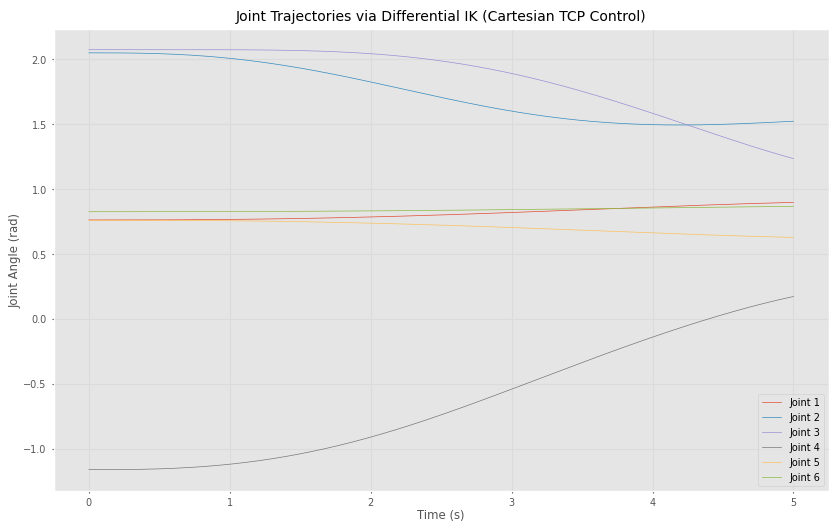

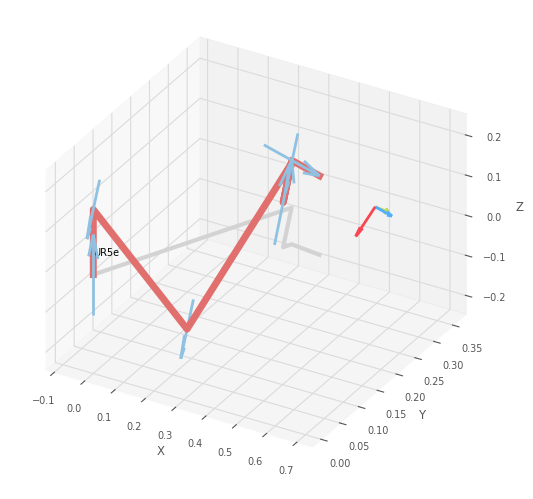

PyPlot3D backend, t = 5.009999999999938, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [26]:
# --- 6. Visualization ---
# Plot joint trajectories
plt.figure(figsize=(10, 6))
for i in range(robot.n):
    plt.plot(t_vec, q_traj[:, i], label=f'Joint {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.title('Joint Trajectories via Differential IK (Cartesian TCP Control)')
plt.legend()
plt.grid(True)
plt.show()

# Animate the robot following the computed joint trajectory.
robot.plot(q_traj, dt=dt, backend='pyplot', movie='ur5e.gif')

rtb.jtraj
